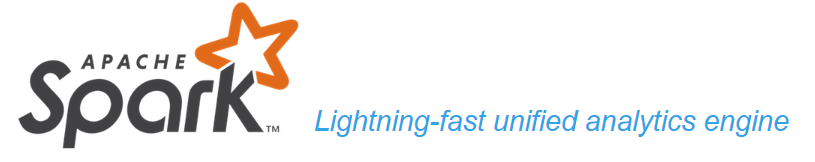

# Anatomy of Spark Job

# Job Submission
Spark job is submitted automatically as soon as action is performed on RDD/DataFrame. Internally it call runJob() on SparkContext/SparkSession which will pass the call to scheduler. Scheduler is made of two parts: 

- DAG scheduler: that breaks down the job into DAG (Directed Acylic Graph) of stages and 
- Task scheduler: that is responsible for submitting the task from each stage to the cluster


# DAG scheduler
- Shuffle map tasks:
Each shuffle map task run on one RDD partition. Based on the partition function it writes output to new set of partitions
- Result task:
Each results task runs a computation on its RDD partition then sends results back to the driver, and the driver assembles the results from each partition into a final results.

DAG scheduler is responsible for splitting stages into tasks for submission to the task scheduler

# Task Scheduling
When the task scheduler is sent a set of tasks, it uses its list of executors that are running for the application and construct mapping of task to executor
Executor first assign task to local process then node-level then rack level and finally cluster level
- Task Execution:
Executor first makes sure that jar and file dependencies are copied to local



In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Basic RDD openration") \
    .getOrCreate()

In [2]:
df1 = spark.range(2, 10000000, 2)
df2 = spark.range(2, 10000000, 4)
step1 = df1.repartition(5)
step12 = df2.repartition(6)
step2 = step1.selectExpr("id * 5 as id")
step3 = step2.join(step12, ["id"])
step4 = step3.selectExpr("sum(id)")
 # 2500000000000


In [3]:
step4.explain()

== Physical Plan ==
*(7) HashAggregate(keys=[], functions=[sum(id#6L)])
+- Exchange SinglePartition
   +- *(6) HashAggregate(keys=[], functions=[partial_sum(id#6L)])
      +- *(6) Project [id#6L]
         +- *(6) SortMergeJoin [id#6L], [id#2L], Inner
            :- *(3) Sort [id#6L ASC NULLS FIRST], false, 0
            :  +- Exchange hashpartitioning(id#6L, 200)
            :     +- *(2) Project [(id#0L * 5) AS id#6L]
            :        +- Exchange RoundRobinPartitioning(5)
            :           +- *(1) Range (2, 10000000, step=2, splits=2)
            +- *(5) Sort [id#2L ASC NULLS FIRST], false, 0
               +- Exchange hashpartitioning(id#2L, 200)
                  +- Exchange RoundRobinPartitioning(6)
                     +- *(4) Range (2, 10000000, step=4, splits=2)


In [4]:
step4.collect()

[Row(sum(id)=2500000000000)]